In [18]:
for i in data.columns[2:-2]:
    data[i] = data[i].apply(make_sep)

In [11]:
str(datetime.datetime.now())[2:-16].replace('-','')

'230401 152834.110826'

In [250]:
def make_sep(number_str):
    return '{0:,}'.format(number_str).replace(',', ' ')


def render_mpl_table_dark(data, file_name='test', col_width=1.0, row_height=0.625, font_size=16,
                     header_color='#C0504D', row_colors=['#F2DCDB', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, dups=dups, **kwargs):
    if ax is None:
        size = (np.array([17.5, 10.8]))
        fig, ax = plt.subplots(figsize=size, dpi=2**8)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, colLoc='center', loc='bottom')

    mpl_table.auto_set_font_size(False)
    cells_dict = dict(six.iteritems(mpl_table._cells))
    
    im = plt.imread(r"C:\Users\Mamed\YandexDisk\_Documents\Проекты\2ГИС 2023\Лого_2ГИС_230401_1600.png")
    ax.figure.figimage(im, 58, 44, zorder=1, alpha=0.5)

    im = plt.imread(r"C:\Users\Mamed\YandexDisk\_Documents\Проекты\2ГИС 2023\лого_ШТ_230401_1600.png")
    ax.figure.figimage(im, 58, 1268, zorder=1, alpha=0.5)
    
    fpath = Path(mpl.get_data_path(), r"C:\Users\Mamed\Downloads\arialnarrow.ttf")
    from colour import Color
    colors = [i.get_hex() for i in list(Color("red").range_to(Color("green"),data.iloc[:20].shape[0]))]
    
    for k in sorted(cells_dict.keys()): #k[0] - строка, k[1] - столбец
        cell = cells_dict[k]
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            rotation='vertical' if k != (0,0) else 'horizontal'
            #cell.set_text_props(ma='left')
            cell.set_text_props(color='w', rotation=rotation, ha='center')
            cell.set_facecolor(header_color)
            cell.set_height(0.07)
        else:
            ha = 'right' if k[1] !=0 else 'left'
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
            cell.set_height(0.008)
            cell.set_text_props(wrap=True, ha=ha)
        if k[1]!=0:
            cell.set_width(0.001)
        else:
            cell.set_width(0.006)
        if k[0] > 0 and k[1] == 0 and cell.get_text().get_text() in dups:
            cell.set_facecolor('#FFC7CE')
            cell.set_text_props(color='#9C0006')
        if k[0] > 0 and k[1] == 5:
            cell.set_facecolor(colors.pop(0).upper()) 
            
        cell.set_text_props(font=fpath)
        cell.set_text_props(fontsize=font_size)
        #ax.axhline(linewidth=1, color='r')
    fig.savefig(f'{file_name}', bbox_inches='tight')

In [183]:
dups = data['Поисковый запрос'][(data['Поисковый запрос'].duplicated())&(data['Рейтинг рубрики'] > 0)].values 

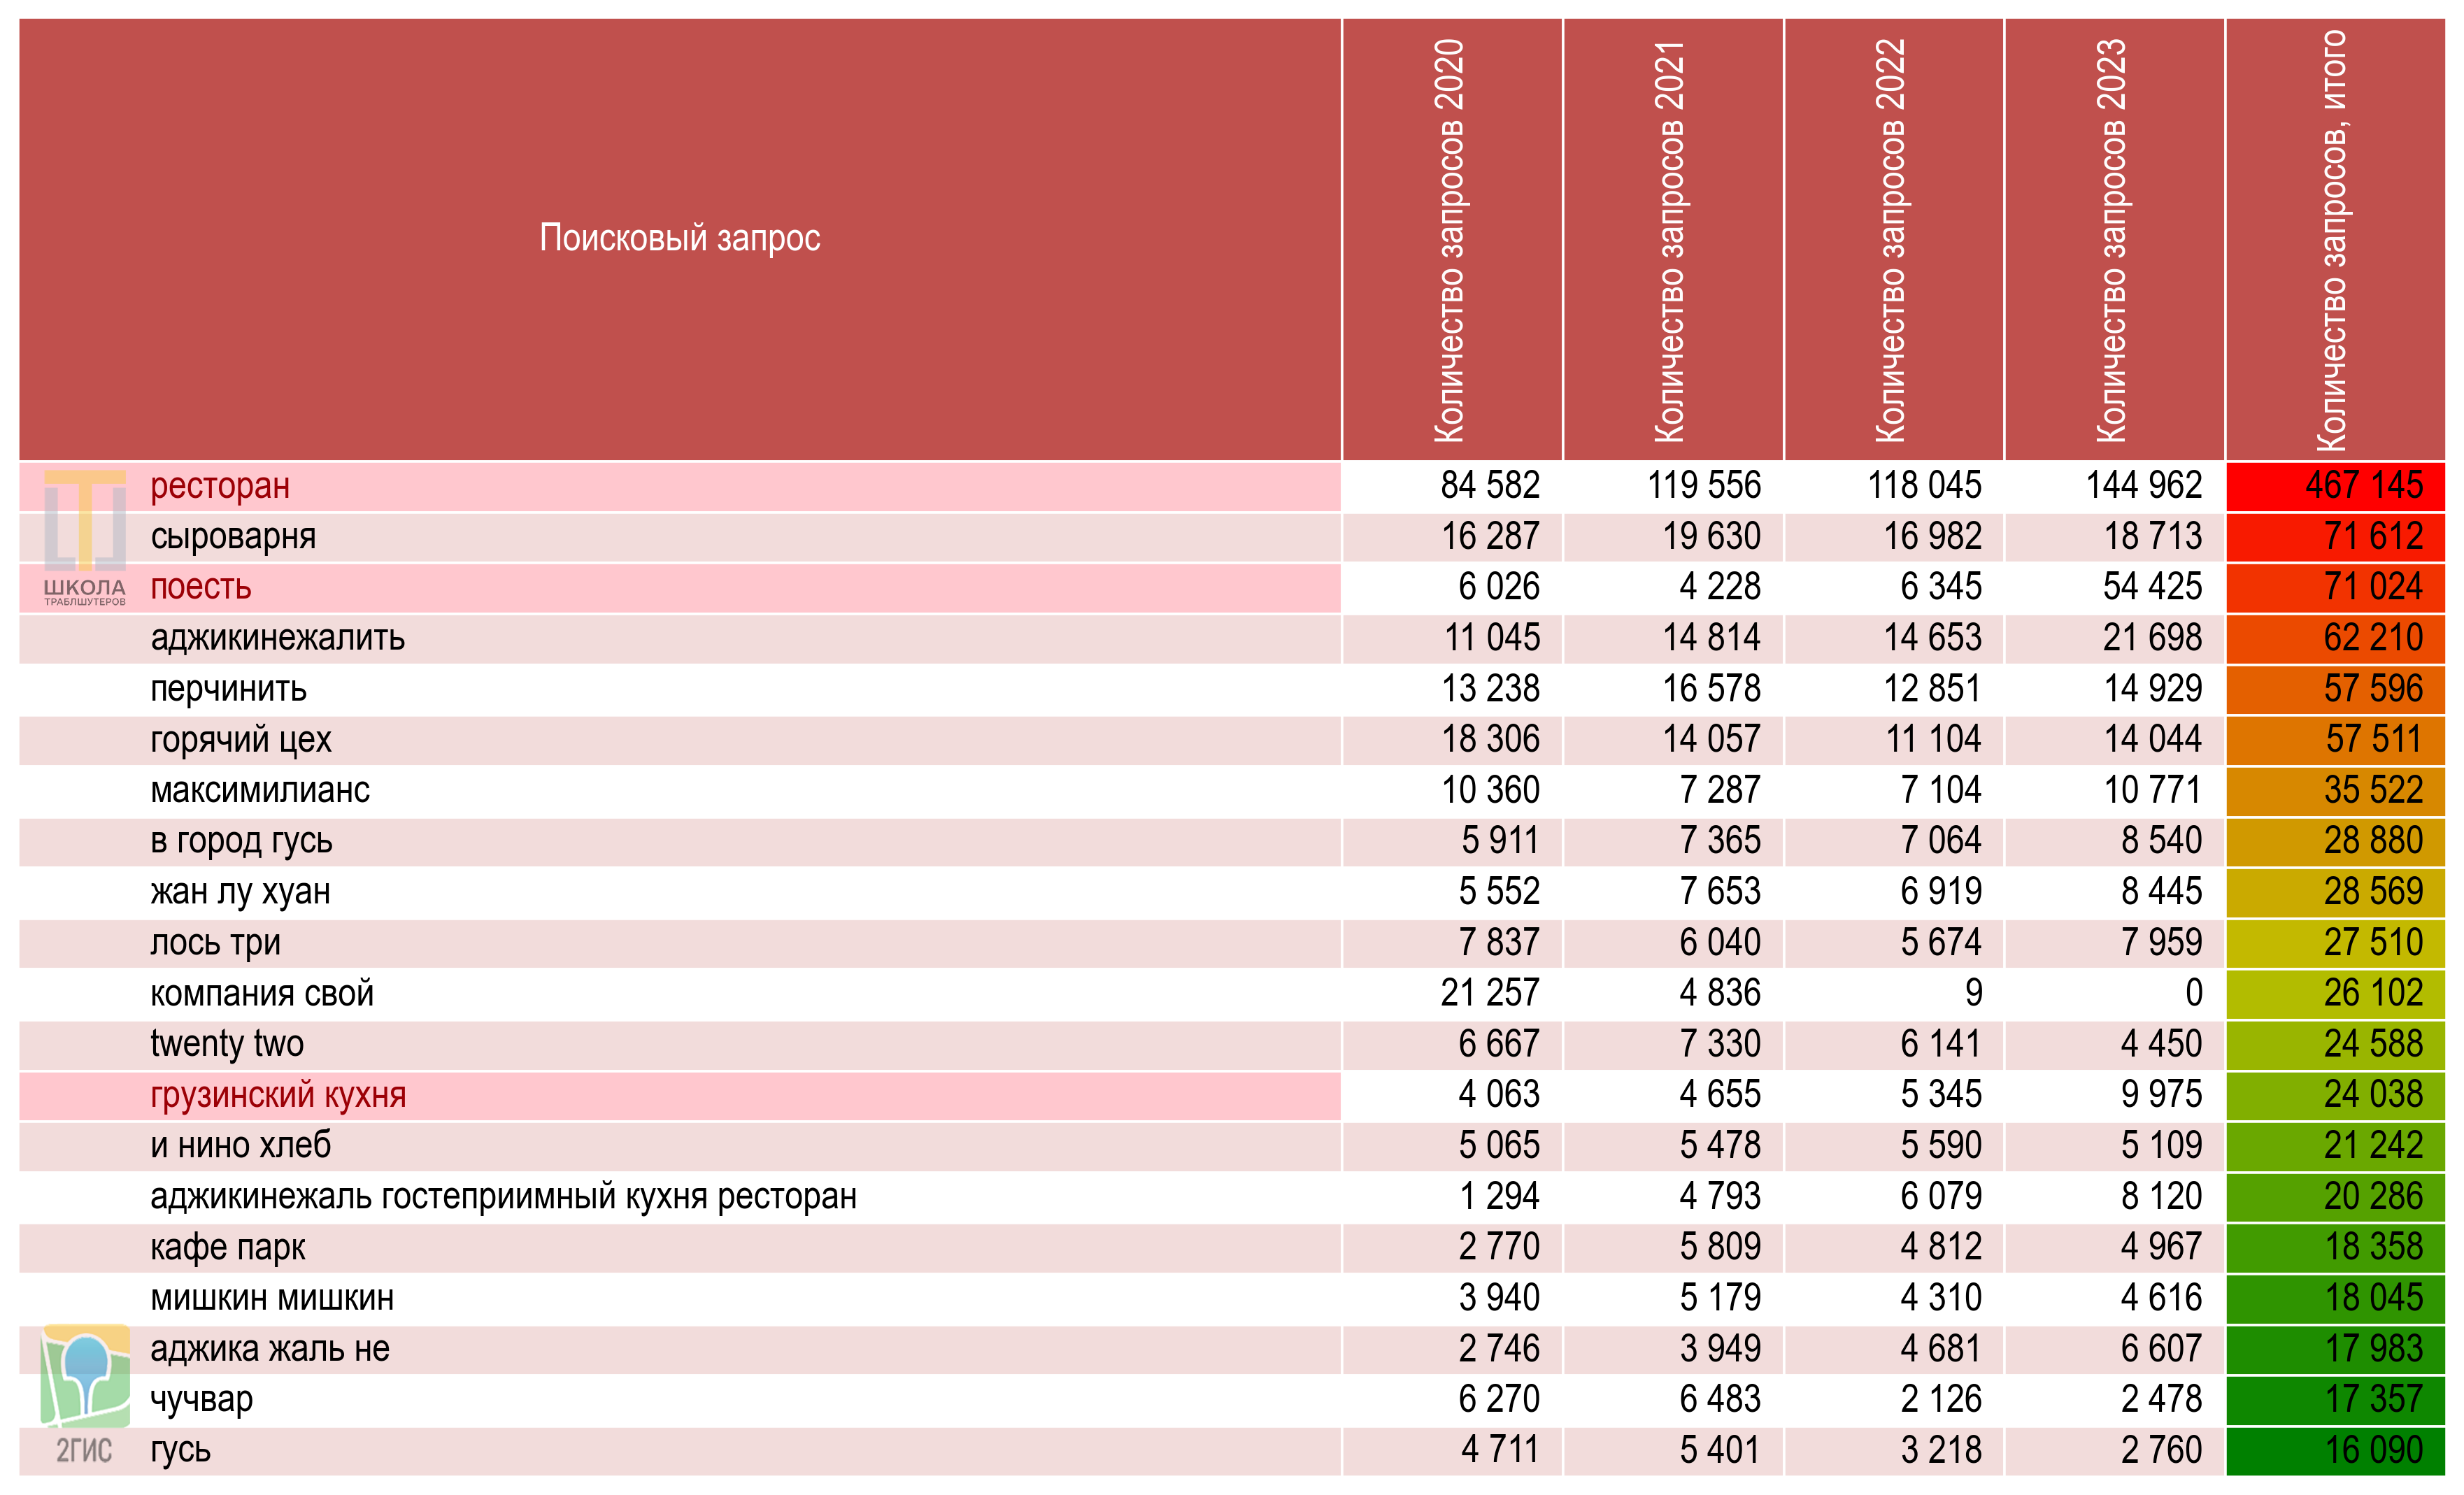

In [251]:
render_mpl_table_dark(data[data['Рейтинг рубрики'] == 5].drop(['Рубрика', 'Рейтинг рубрики', 'Рейтинг по запросам, итого'], axis=1).iloc[:20], dups=dups)